In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
#import lightkurve as lk
import glob
import pickle
import pyphot
from pyphot import unit
from scipy import stats
import emcee
import corner
import pandas as pd
from bisect import bisect_left

import sys
plt.rcParams.update({'font.size': 22})

sys.path.append('../../WD_models/')
from sed_fitter import FitSED

plt.style.use('vedant')

from astropy import constants as c
from astropy import units as u

k = 1.38e-16
h = 6.626e-27

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

ca2k = 3933

### NOT Spectrum

Text(0, 0.5, 'Flux')

<Figure size 720x432 with 0 Axes>

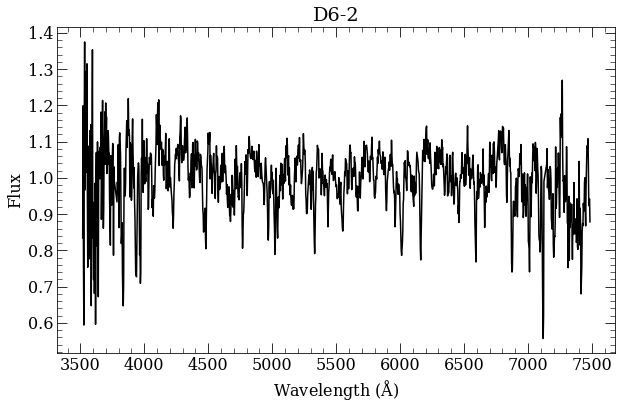

In [2]:
def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

df = pd.read_csv('d62_NOT.txt', sep = ' ', header = None)

not_wl = np.array(df[1])[50:-500]
not_fl = np.array(df[2])[50:-500]

plt.figure(figsize = (10, 6))
continuum = scipy.ndimage.gaussian_filter1d(not_fl, sigma = 75)

plt.figure(figsize = (10, 6))
plt.plot(not_wl, not_fl/continuum, 'k')
plt.title('D6-2')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

### Load Model Spectra

In [4]:
# Set stellar parameters

mass = 0.5 * c.M_sun
radius = 0.22 * c.R_sun

g = (c.G * mass / radius**2).to(u.cm/u.s**2)
logg = np.log10(g.value)
print(logg)

CAH = -11.3

5.45219226999474


In [5]:
# Load Blouin models

wd_interp = pickle.load(open('blouin/interpwd.pkl', 'rb'))
lib = pyphot.get_library()

n_points = 15000
lamgrid = 10**np.linspace(np.log10(2000), np.log10(99000), n_points)

def get_wd(teff, logg, cah = CAH, wl = lamgrid):
    return 10**wd_interp((logg, teff, cah, np.log10(wl)))

abs_distance = 10

def get_cal_spec_wd(teff, radius, plx, logg = logg, wl = lamgrid, cah = CAH):
    
    distance = 1000/plx
    
    mfl = get_wd(teff, logg, cah = cah, wl = wl)

    radius = radius * radius_sun
    distance = distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl * 1.0E+23         
    
    return mfl # in jansky

In [6]:
## Archival data for D62 (double-check)

mags = dict(J = 16.583, H = 16.575, Ks = 15.470, W1 = 15.383, 
            W2 = 14.385, W3 = 11.862, W4 = 9.230, NUV = 19.9852, Py = 17.3131,
           Su = 17.730 - 0.04, Sg = 17.163, Sr = 17.025, Si = 17.085 + 0.015, Sz = 17.154 + 0.03)

# e_mags = dict(J = 0.134, H = np.nan, Ks = np.nan,
#               W1 = 0.047, W2 = 0.06, W3 = 0.206, W4 = 0.531, NUV = 0.1359, Py = 0.0175,
#              Su = 0.012, Sg = 0.004, Sr = 0.005, Si = 0.005, Sz = 0.012) errors without floor

e_mags = dict(J = 0.134, H = 0.135, Ks = np.nan, 
              W1 = 0.047, W2 = 0.06, W3 = 0.206, W4 = 0.531, NUV = 0.1359, Py = 0.03,
             Su = 0.03, Sg = 0.03, Sr = 0.03, Si = 0.03, Sz = 0.03)


#gaia_plx = np.array((1.0517, 0.1093)) DR2

gaia_plx = np.array((1.193525, 0.065421)) # EDR3!!!

# pm: 259.5137
# pmra_err 0.06761136
# pmdec_err 0.058017593

gal_coord = [077.1415311366616, -19.8828082213587]

In [7]:
import dustmaps.bayestar
#dustmaps.bayestar.fetch() # if not already downloaded
from dustmaps.bayestar import BayestarQuery

In [8]:
bstar = BayestarQuery()

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 42.702 s
  pix_info:   0.586 s
   samples:  26.756 s
      best:   5.215 s
       nan:   0.612 s
      sort:   9.206 s
       idx:   0.327 s


In [9]:
coords = SkyCoord(l = gal_coord[0] * u.deg, b = gal_coord[1] * u.deg, frame = 'galactic',
                 distance = (1000 / gaia_plx[0]) * u.pc)

In [10]:
coords

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (77.14153114, -19.88280822, 837.85425525)>

In [11]:
ebv_samples = bstar(coords, mode='samples')

In [12]:
ebv_samples = np.array(ebv_samples).astype(float)

In [104]:
# Empirical extinction coefficients from Yuan et al 2013

ext_R = dict(
    
    NUV = 7.24,
    Su = 4.39,
    Sg = 3.3,
    Sr = 2.31,
    Si = 1.71,
    Sz = 1.29,
    J = 0.72,
    H = 0.46,
    W1 = 0.18,
    W2 = 0.16
)

In [170]:
import extinction

In [171]:
dustlaw = extinction.fm07

In [172]:
bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']

pyphot_bands = ['SDSS_u', 'SDSS_g','SDSS_r','SDSS_i','SDSS_z']

#ext_Rs = np.array([ext_R[band] for band in bands]) #+ 0.25

msigma = 1.5 # Sigma of model spectrum

In [174]:
def get_sed_wd(teff, radius, plx, logg = logg, bands = pyphot_bands, to_mag = False, cah = CAH,
              vbands = bands):
    fl = get_cal_spec_wd(teff, radius, plx, logg, cah = CAH) / 1e-23
    wl = lamgrid * unit['AA']
    fl = fl * unit['flam']
    sed = [];    
    
    for i,band in enumerate(bands):
        f = lib[band]
        se = f.get_flux(wl, fl) * 1e-23 #* u.Jy
        sed.append(se.value)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed / 3631) #+ 48.60
    return np.ravel(sed)

In [175]:
# Initialize SED -> flux converter

fitsed = FitSED(bands = bands)

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [176]:
ebv_samples

array([0.08, 0.04, 0.08, 0.08, 0.07])

In [211]:
# Make SED, test WD model is working

raw_sed = np.array([mags[band] for band in bands]).ravel()
e_sed = np.array([e_mags[band] for band in bands]).ravel()

wls = np.array([fitsed.mean_wl[band] for band in bands])

e_gr = ebv_samples * 0.901 # GSZ 2019
av_samples = (e_gr - 0.03) / 0.269
fid_exts = dustlaw(wls, np.median(av_samples))

#fid_exts = np.median(ebv_samples) * ext_Rs

sed = raw_sed

fluxes = fitsed.mag_to_flux(sed)
e_fluxes = e_sed * fluxes
model_flux = get_sed_wd(7000, 0.2, gaia_plx[0], logg = logg, bands = pyphot_bands)

corr_fluxes = fitsed.mag_to_flux(sed + fid_exts) # Correct fiducial extinction for plots

#@corr_fluxes = fitsed.mag_to_flux(sed)

In [212]:
fid_exts

array([0.24224405, 0.19388706, 0.13475884, 0.09745041, 0.07043933])

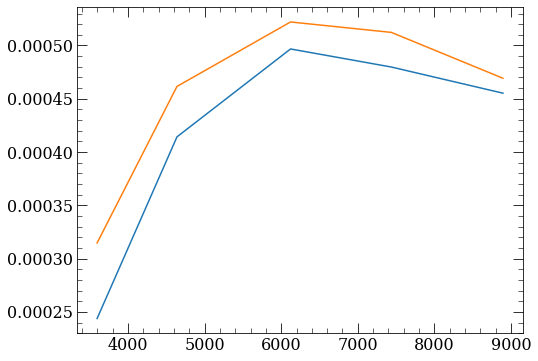

In [213]:
plt.plot(wls, corr_fluxes)
plt.plot(wls, model_flux)

## ** can stop here and move to analyze excess if chains already saved **

In [215]:
def loglik(params):
    
    teff, radius, av, plx = params
    
    model_sed = get_sed_wd(teff, radius, plx, logg = logg, cah = CAH, to_mag = True)
    
#     ebv = np.random.choice(ebv_samples) # Sample random EBV from Bayestar
#     e_gr = ebv * 0.901 # GSZ 2019
#     av = (e_gr - 0.03) / 0.269

    exts = dustlaw(wls, av)
        
    diff = raw_sed + exts - model_sed
    
    return -0.5 * np.sum(diff**2/e_sed**2)

def logprior(params):
    teff, radius, av, plx = params
    
    if teff <= 6000 or teff >= 9000:
        return -np.inf
    
    if radius <= 0.005 or radius >= 1:
        return -np.inf
    
    plx_prior =  stats.norm(loc = gaia_plx[0], scale = gaia_plx[1]).logpdf(plx) # paralax 'prior' from Gaia data
    av_prior = stats.norm(loc = np.mean(av_samples), scale = np.std(av_samples)).logpdf(av)
    
    return plx_prior + av_prior

def logprob(params):
    
    lp = logprior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglik(params)

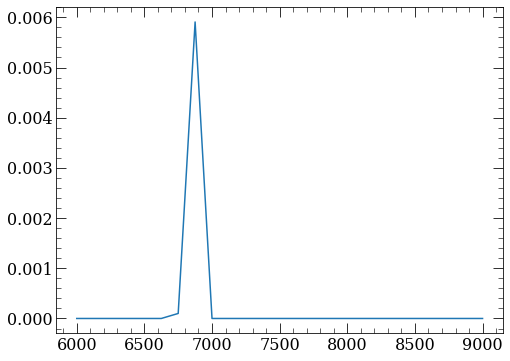

In [218]:
teffs = np.linspace(6000, 9000, 25)
liks = [logprob([teff, 0.2, np.mean(av_samples), gaia_plx[0]]) for teff in teffs]

plt.plot(teffs, np.exp(liks))

### Initial Fit to Fix CAH and Logg

In [219]:
from scipy.optimize import minimize

nll = lambda params: -logprob((params[0], params[1], np.mean(av_samples), 
                               gaia_plx[0])) # Fix parallax, solve for Teff and radius

ITERATION 0
[6.61152895e+03 2.12700060e-01]


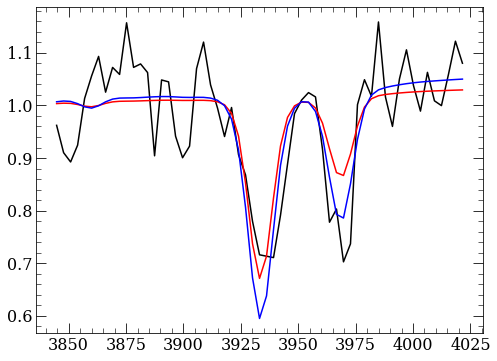

ITERATION 1
[6.59263578e+03 2.13514311e-01]


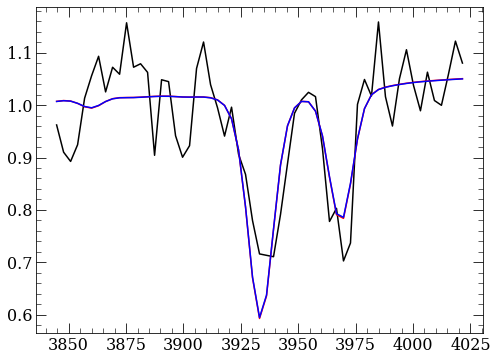

terminating early


In [226]:
# Initial Parameters

CAH = -12
logg = 5.3

initial = [7000, 0.2] # Teff, radius


cahs = [];
loggs = [];

cahs.append(CAH)
loggs.append(logg)

for ii in range(10):
    print('='*50)
    print('ITERATION %i'%ii)
    
    soln = minimize(nll, initial,
                   method = 'Nelder-Mead')

    bestfit = soln.x
    print(bestfit)
    bestfit = np.concatenate((bestfit, [gaia_plx[0]]))
    initial = soln.x

    cwl, cfl = cont_norm(not_wl, not_fl, ca2k, 90, 25)
    model_flux = get_cal_spec_wd(*bestfit, wl = not_wl, cah = CAH)
    model_flux = scipy.ndimage.gaussian_filter1d(model_flux, sigma = msigma)
    mcwl, mcfl = cont_norm(not_wl, model_flux, ca2k, 90, 25)

    plt.plot(cwl, cfl, 'k')
    plt.plot(mcwl, mcfl, 'r')
    
    mass = 0.5 * c.M_sun
    radius = soln.x[1] * c.R_sun

    g = (c.G * mass / radius**2).to(u.cm/u.s**2)
    
    dlogg = np.abs(logg - np.log10(g.value))
    
    logg = np.log10(g.value)

    def resid(params):
        cah = params

        if logg <=5 or logg >= 7 or cah >= -8 or cah <= -12:
            return 1e23

        model_flux = get_cal_spec_wd(*bestfit, logg = logg, cah = cah, wl = not_wl)
        model_flux = scipy.ndimage.gaussian_filter1d(model_flux, sigma = msigma)
        mcwl, mcfl = cont_norm(not_wl, model_flux, ca2k, 90, 25)

        diff = (mcfl - cfl)**2

        return np.mean(diff)

    res = scipy.optimize.minimize(resid, x0 = [CAH], method = 'Nelder-Mead')

    model_flux = get_cal_spec_wd(*bestfit, wl = not_wl, cah = res.x, logg = logg)
    model_flux = scipy.ndimage.gaussian_filter1d(model_flux, sigma = msigma)
    mcwl, mcfl = cont_norm(not_wl, model_flux, ca2k, 90, 25)
    plt.plot(mcwl, mcfl, 'b')
    
    dcah = np.abs(CAH - res.x)
    
    CAH = res.x

    cahs.append(CAH)
    loggs.append(logg)
    
    plt.show()
    
    if dlogg < 0.05 and dcah < 0.05:
        print('terminating early')
        break

/Users/vedantchandra/opt/anaconda3/envs/d62/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


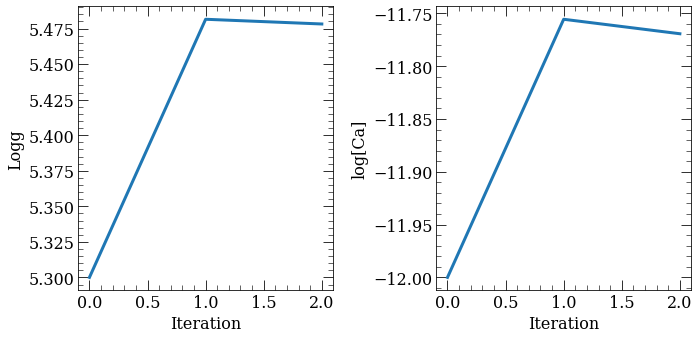

In [227]:
plt.figure(figsize = (10, 5))

kw = dict(lw = 3)

plt.subplot(121)
plt.plot(loggs, **kw)
plt.ylabel('Logg')
plt.xlabel('Iteration')

plt.subplot(122)

plt.plot(cahs, **kw)
plt.ylabel('log[Ca]')
plt.xlabel('Iteration')

plt.tight_layout()

Text(0, 0.5, 'Normalized Flux')

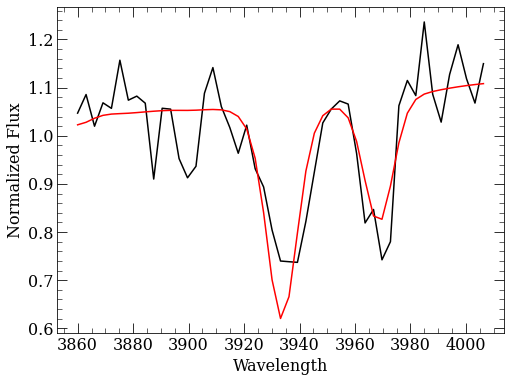

In [229]:
ca2k = 3933

cwl, cfl = cont_norm(not_wl, not_fl, ca2k, 75, 25)
plt.plot(cwl, cfl, 'k')

model_flux = get_cal_spec_wd(*bestfit, wl = not_wl, cah = CAH, logg = logg)
model_flux = scipy.ndimage.gaussian_filter1d(model_flux, sigma = msigma)
mcwl, mcfl = cont_norm(not_wl, model_flux, ca2k, 75, 25)
plt.plot(mcwl, mcfl, 'r')

plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')

Text(0.5, 1.0, 'Initial SED Fit')

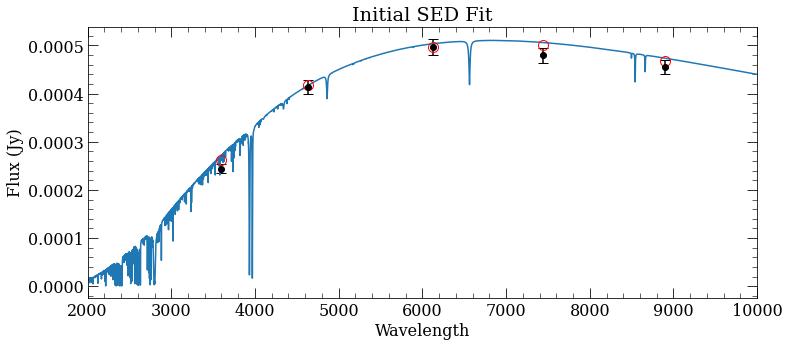

In [230]:
plt.figure(figsize = (12, 5))

plt.errorbar(wls, corr_fluxes, linestyle = 'none', marker = 'o', color = 'k', capsize = 5, yerr = e_fluxes)
plt.plot(lamgrid, get_cal_spec_wd(*bestfit, wl = lamgrid))
plt.plot(wls, get_sed_wd(*bestfit), 'ro', markerfacecolor = 'none', markersize = 10, linewidth = 5)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(2000, 1e4)

plt.xlabel("Wavelength")
plt.ylabel('Flux (Jy)')

plt.title('Initial SED Fit')

### Full MCMC Fit

In [233]:
init_params = np.array([bestfit[0], bestfit[1], np.mean(av_samples), bestfit[2]])

In [235]:
ndim, nwalkers = 4, 100

p0 = np.zeros((nwalkers, ndim))

for jj in range(ndim):
    p0[:, jj] = init_params[jj] + init_params[jj] * 0.01 * np.random.normal(size = nwalkers) # Initial 1% N-ball
    
paramnames = ['$T_{eff}/K$', '$R/R_\odot$', '$A_V$', r'$\varpi/mas$']

In [236]:
filename = "emcee_new.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, backend = backend)

In [237]:
# Burn-in chains

b0 = sampler.run_mcmc(p0, 50, progress = True);

100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


Text(0.5, 0, 'Steps')

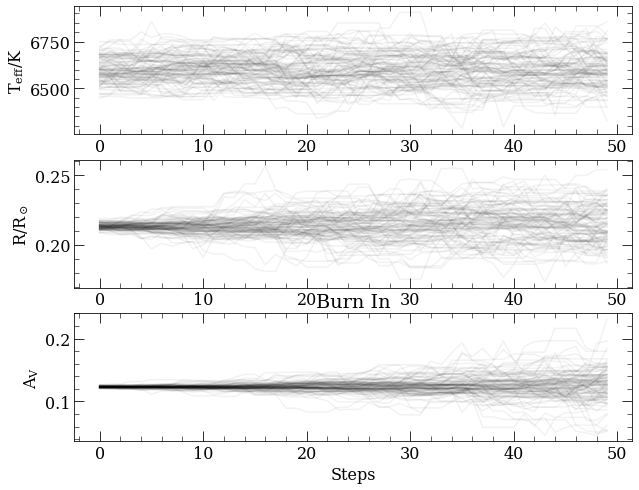

In [238]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.plot(sampler.chain[:, :, 0].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[0])

plt.subplot(312)
plt.plot(sampler.chain[:, :, 1].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[1])


plt.subplot(313)
plt.plot(sampler.chain[:, :, 2].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[2])
plt.title('Burn In')
plt.xlabel('Steps')

In [239]:
# Main production steps

sampler.reset()

b1 = sampler.run_mcmc(b0, 1000, progress = True);

100%|██████████| 1000/1000 [49:06<00:00,  2.95s/it]


In [240]:
print(len(sampler.flatchain))

100000


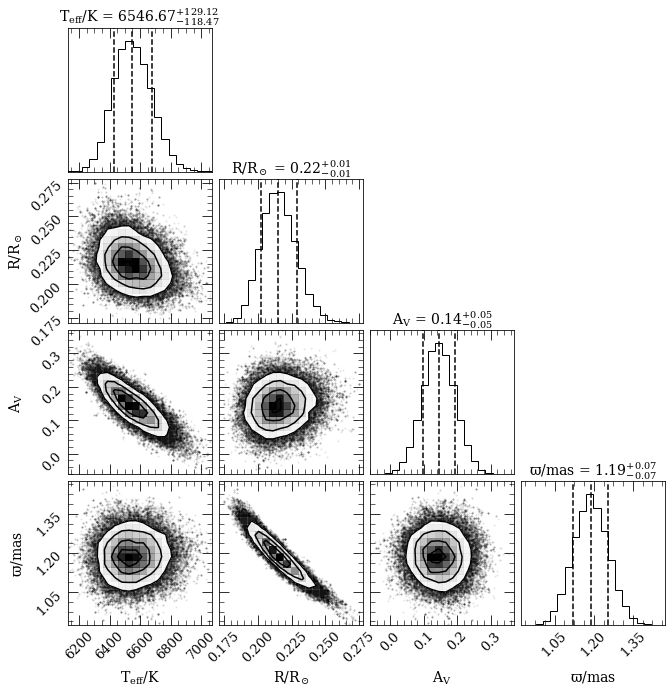

In [241]:
plt.rcParams.update({'font.size': 13})

f = corner.corner(sampler.flatchain, show_titles = True, quantiles = (0.16, 0.5, 0.84),
                 labels = paramnames,
                 title_kwargs = dict(fontsize = 14), label_kwargs = dict(fontsize = 14), fontsize = 14)

#plt.tight_layout()
#lt.subplots_adjust()
plt.savefig('fig/main_corner.pdf', bbox_inches = 'tight')

In [242]:
np.savetxt('sed_mcmc/chain.txt', sampler.flatchain)

In [243]:
np.savetxt('sed_mcmc/logprob.txt', sampler.get_log_prob(flat = True))

In [244]:
radius = sampler.flatchain[:, 1]*c.R_sun
#mass = 0.6 * c.M_sun
#e_mass = 0.15 * c.M_sun
#mass_samples = mass + e_mass * np.random.normal(size = len(sampler.flatchain))
#mass_samples[mass_samples < 0.2 * c.M_sun] = np.median(mass_samples)
mass_samples = c.M_sun * np.random.uniform(0.2, 0.8, size = len(sampler.flatchain))
g = (c.G * mass_samples / radius**2).to(u.cm/u.s**2)
loggs = np.log10(g.value)

allparams = np.vstack((sampler.flatchain.T, loggs)).T

In [245]:
burn = 5000
thin = 2

len(allparams[burn::thin])

47500

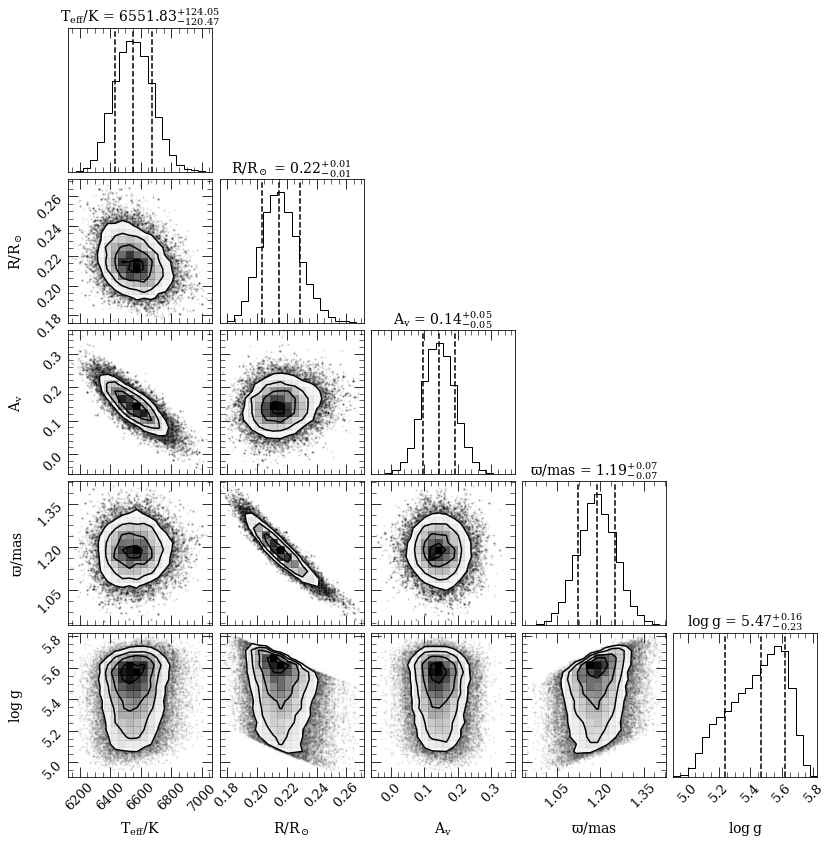

In [247]:
plt.rcParams.update({'font.size': 13})

f = corner.corner(allparams[burn::thin], show_titles = True, quantiles = (0.16, 0.5, 0.84),
                 labels = [r'$T_{eff}/K$', r'$R/R_\odot$', r'$A_v$', r'$\varpi/mas$', r'$log\,g}$'],
                 title_kwargs = dict(fontsize = 14), label_kwargs = dict(fontsize = 14), fontsize = 14)

plt.savefig('fig/sedfit_corner.pdf')

In [248]:
np.savetxt('sed_mcmc/emcee_allparams.dat', allparams)

Text(0.5, 0, 'Steps')

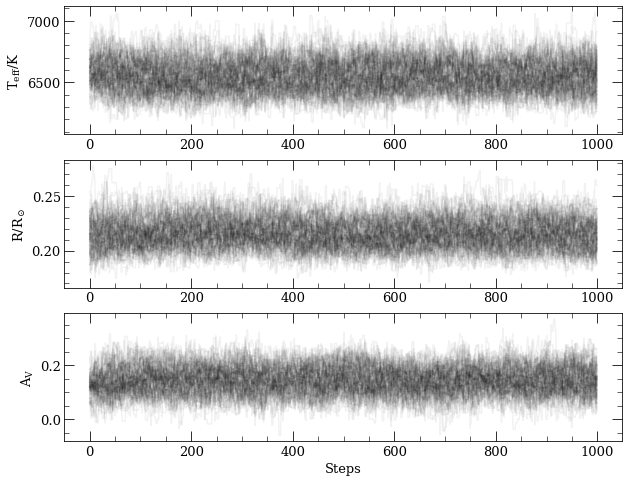

In [249]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.plot(sampler.chain[:, :, 0].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[0])

plt.subplot(312)
plt.plot(sampler.chain[:, :, 1].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[1])


plt.subplot(313)
plt.plot(sampler.chain[:, :, 2].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[2])

plt.xlabel('Steps')

In [254]:
bestfit = sampler.flatchain[np.argmax(sampler.get_log_prob(flat = True))]

bestfit = np.array([bestfit[0], bestfit[1], bestfit[3]])

In [255]:
np.savetxt('txt/bestfit.txt', bestfit)

Text(0.5, 1.0, 'Initial SED Fit')

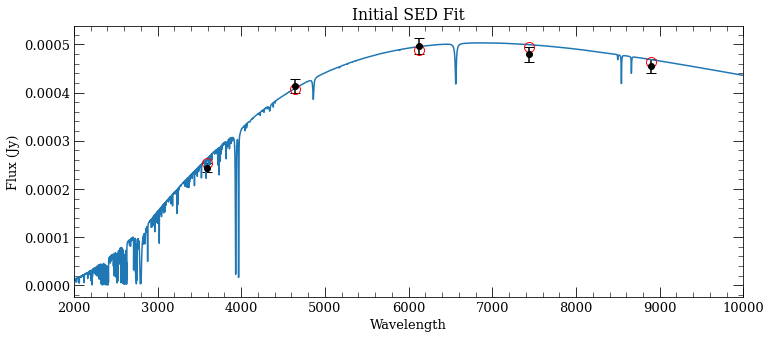

In [256]:
plt.figure(figsize = (12, 5))

plt.errorbar(wls, corr_fluxes, linestyle = 'none', marker = 'o', color = 'k', capsize = 5, yerr = e_fluxes)
plt.plot(lamgrid, get_cal_spec_wd(*bestfit, wl = lamgrid))
plt.plot(wls, get_sed_wd(*bestfit), 'ro', markerfacecolor = 'none', markersize = 10, linewidth = 5)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(2000, 1e4)

plt.xlabel("Wavelength")
plt.ylabel('Flux (Jy)')

plt.title('Initial SED Fit')

## Analyse Excess

In [292]:
# Once you move to this section of the notebook, do not change anything above. If you do,
# Re-run the whole notebook again. 

In [293]:
#bands = ['NUV', 'Su', 'Sg', 'Sr', 'Si', 'Sz', 'J', 'H', 'Ks', 'W1', 'W2', 'W3', 'W4']

bands = ['NUV', 'Su', 'Sg', 'Sr', 'Si', 'Sz', 'J', 'H', 'W1', 'W2']

pyphot_bands = ['GALEX_NUV', 'SDSS_u', 'SDSS_g','SDSS_r','SDSS_i','SDSS_z', '2MASS_J', '2MASS_H',
                'WISE_RSR_W1', 'WISE_RSR_W2']

lcen = dict(NUV =  2328, Su =  3565, Sg = 4700, Sr = 6174, Si = 7533, Sz = 8781, J = 12390, 
            H = 16487, W1 = 34655, W2 = 46443 )
fwhms = dict(NUV = 795, Su = 582, Sg = 1262, Sr = 1149, Si = 1238, Sz = 994, J = 2149, H = 2609, 
           W1 = 6357, W2 = 11073)

In [294]:
fitsed = FitSED(bands = bands)

initialized with atm_type = H and bands = ['NUV', 'Su', 'Sg', 'Sr', 'Si', 'Sz', 'J', 'H', 'W1', 'W2']


In [309]:
raw_sed = np.array([mags[band] for band in bands]).ravel()
e_sed = np.array([e_mags[band] for band in bands]).ravel()

#exts = np.array([ext_R[band] * np.median(ebv_samples) for band in bands]) # Use fiducial extinction value

In [310]:
chain = np.loadtxt('sed_mcmc/chain.txt')
logprob = np.loadtxt('sed_mcmc/logprob.txt')

In [311]:
bestfit = np.loadtxt('txt/bestfit.txt')

In [312]:
exts = dustlaw(wls, np.median(chain[:, 2]))

sed = raw_sed + exts

wls = np.array([lcen[band] for band in bands])
bws = np.array([fwhms[band] for band in bands])
fluxes = fitsed.mag_to_flux(sed)
e_fluxes = fluxes * e_sed

In [313]:
exts

array([0.41073303, 0.22477615, 0.17620636, 0.12259403, 0.08785636,
       0.06651076, 0.0351895 , 0.02085335, 0.00523286, 0.00319911])

### Black-Body Model

Text(0.5, 0, 'Wavelength')

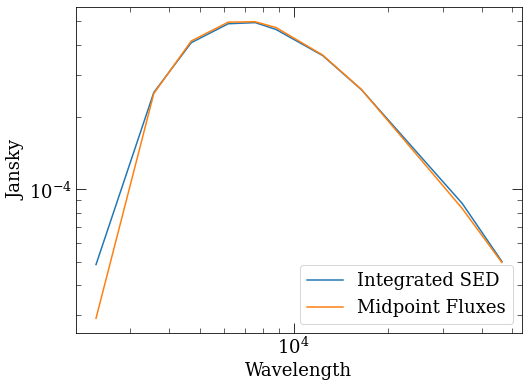

In [314]:
plt.plot(wls, get_sed_wd(*bestfit, logg = logg, bands = pyphot_bands), label = 'Integrated SED')

plt.plot(wls, get_cal_spec_wd(*bestfit, wl = wls), label = 'Midpoint Fluxes')

plt.yscale('log')
plt.xscale('log')

plt.legend()

plt.ylabel("Jansky")
plt.xlabel("Wavelength")

In [315]:
model_flux = get_sed_wd(*bestfit, logg = logg, bands = pyphot_bands)

IR_wls = np.array(wls)
IR_excess = fluxes - model_flux

np.savetxt('txt/stellar_model.txt', model_flux)
np.savetxt('txt/wls.txt', wls)

In [347]:
def bb_model(wl, T, R):
    
    R = R * c.R_sun
    D = (1000 / bestfit[2]) * c.pc
    
    nu = c.c / (wl * 1e-10 * u.m)
    
    sa = np.pi * R**2 / D**2
    
    t1 = 2 * c.h * nu**3 / c.c**2
    t2 = np.exp(c.h * nu / (c.k_B * T * u.K)) - 1
    
    return (sa * t1 / t2).to(u.Jy).value

p0 = [1000, 3]
nmc = 250

teffs = [];
Rs = [];

for ii in tqdm(range(nmc)):
    obs_sample = IR_excess + np.random.normal(size = len(IR_excess)) * e_fluxes 
    p,cov = scipy.optimize.curve_fit(bb_model, IR_wls, obs_sample, p0 = p0, maxfev = 10000)
    teffs.append(p[0])
    Rs.append(p[1])

100%|██████████| 250/250 [00:03<00:00, 64.93it/s]


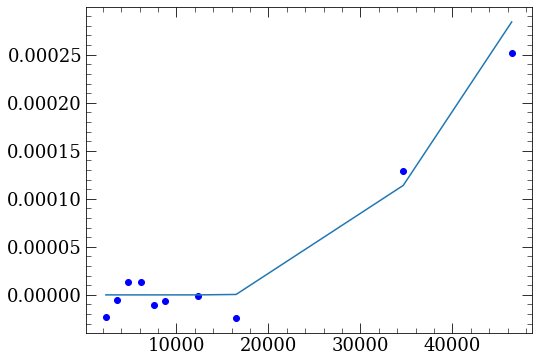

In [348]:
plt.plot(IR_wls, IR_excess, 'bo')
plt.plot(IR_wls, bb_model(IR_wls, p[0], p[1]))

(array([ 2.,  0.,  2.,  4.,  2.,  8., 10., 13., 24., 10., 27., 13., 23.,
        15., 19., 24., 16., 14.,  4.,  9.,  3.,  1.,  3.,  1.,  3.]),
 array([562.64140739, 572.41204487, 582.18268234, 591.95331982,
        601.72395729, 611.49459477, 621.26523224, 631.03586972,
        640.80650719, 650.57714467, 660.34778214, 670.11841962,
        679.88905709, 689.65969457, 699.43033205, 709.20096952,
        718.971607  , 728.74224447, 738.51288195, 748.28351942,
        758.0541569 , 767.82479437, 777.59543185, 787.36606932,
        797.1367068 , 806.90734427]),
 <BarContainer object of 25 artists>)

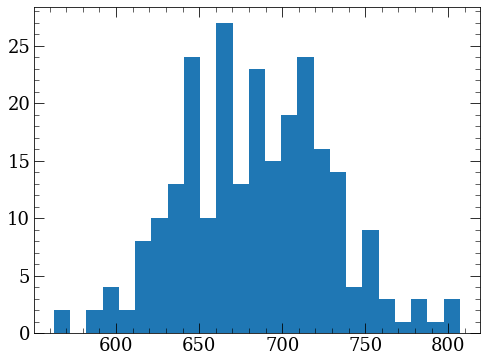

In [349]:
plt.hist(teffs)

(array([ 6.,  3., 11., 18., 21., 23., 26., 24., 25., 21., 10., 21.,  9.,
         9.,  7.,  6.,  2.,  1.,  2.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([3.37588689, 3.59541497, 3.81494304, 4.03447112, 4.25399919,
        4.47352727, 4.69305534, 4.91258342, 5.13211149, 5.35163956,
        5.57116764, 5.79069571, 6.01022379, 6.22975186, 6.44927994,
        6.66880801, 6.88833609, 7.10786416, 7.32739224, 7.54692031,
        7.76644839, 7.98597646, 8.20550454, 8.42503261, 8.64456069,
        8.86408876]),
 <BarContainer object of 25 artists>)

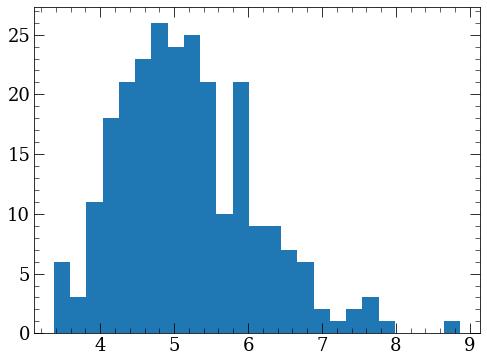

In [350]:
plt.hist(Rs)

In [355]:
teff = np.mean(teffs)
R = np.mean(Rs)

e_teff = np.std(teffs)
e_rad = np.std(Rs)

In [356]:
print(teff, e_teff)
print(R, e_rad)

684.529146197371 44.700575000682974
5.171737583914533 0.917434121333224


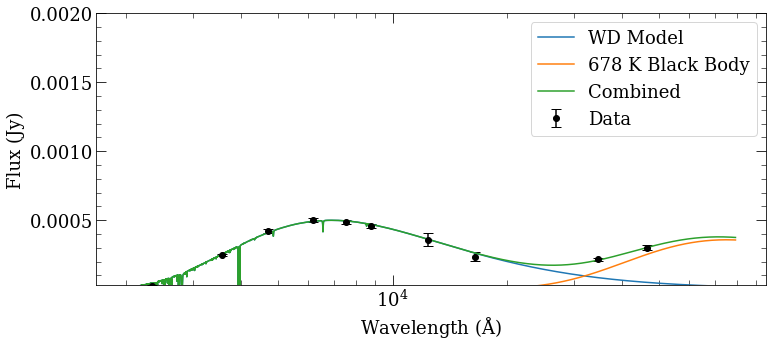

In [320]:
plt.figure(figsize = (12, 5))

plt.errorbar(wls, fluxes, yerr = e_fluxes, color = 'k', linestyle = 'none', marker = 'o', capsize = 5,
            label = 'Data')


# plt.plot(wls, model_flux,color = 'blue', marker = 'o', mfc = 'none', markersize = 15,
#         label = 'DA WD Model')

#plt.yscale('log')
plt.xscale('log')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux (Jy)')

grid = np.logspace(3.302, 4.9, 10000)
excess_model = bb_model(grid, p[0], p[1])

plt.plot(grid, get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), color = 'C0', label = 'WD Model')
plt.plot(grid, excess_model, color = 'C1', label = '%i K Black Body' % p[0])
plt.plot(grid, get_cal_spec_wd(*bestfit, wl = grid, cah = CAH) + excess_model, color = 'C2', label = 'Combined')


plt.ylim(3e-5, 2e-3)
plt.legend()

#plt.savefig('fig/d62_SED.pdf', bbox_inches = 'tight', dpi = 300)

### Jura Flat Disk

In [321]:
from astropy import constants as c
import astropy.units as u
from scipy import integrate
from tqdm import tqdm

In [322]:
def jura_disk(wl, D, i, T_star, R_star, T_in, T_out):
    
    if wl < 1e4:
        return 0
    
    nu = c.c / (wl * 1e-10 * u.m)
    R_star = R_star * c.R_sun
    D = D * c.pc
    T_star = T_star * u.K
    T_in = T_in * u.K
    T_out = T_out * u.K
    
    t1 = 12 * np.pi**(1/3) * R_star**2 * np.cos(i * np.pi / 180) / D**2
    t2 = (2 * c.k_B * T_star / (3 * c.h * nu)) ** (8 / 3)
    t3 = c.h * nu**3 / c.c**2
    
    xmin = c.h * nu / (c.k_B * T_in)
    xmax = c.h * nu / (c.k_B * T_out)
            
#     print(nu)
#     print(xmin, xmax)
#     print(T_out)

#     print(nu)
#     print(T_out)
#     print(T_in)
    
    if T_out < 1 * u.K or T_in < 1 * u.K:
        return 1e20
        
    fn = lambda x: x**(5/3) / (np.exp(x) - 1)
    t4 = integrate.quad(fn, xmin.value, xmax.value)[0]
    
        
    return (t1*t2*t3*t4).to(u.Jy).value

def disk_model(wl, D, i, T_star, R_star, T_in, T_out):
    return np.array([jura_disk(wli, D, i, T_star, R_star, T_in, T_out) for wli in wl]) #* u.Jy

In [323]:
wl_grid = np.logspace(3.2, 5, 100)

In [324]:
# Define initial disk parameters

D = 1000 / bestfit[2] # fixed
i = 0 # fixed
R_star = bestfit[1]
T_star = bestfit[0]

T_in = 1250
T_out = 100 # fixed


disk_sed = disk_model(wl_grid, D, i, T_star, R_star, T_in, T_out)

In [325]:
nmc = 250
prms = [];

for ii in tqdm(range(nmc)):
    def fit_disk(params):
        T_in,T_out = params
        obs_sample = IR_excess + np.random.normal(size = len(IR_excess)) * e_fluxes 
        resid = obs_sample - disk_model(IR_wls, D, i, T_star, R_star, T_in, T_out).ravel()
        return np.sum(resid**2)

    p0 = [np.random.uniform(501, 5000), np.random.uniform(5, 500)] # only fit inner temperature

    res = scipy.optimize.minimize(fit_disk, p0, method = "Powell", bounds = [(501, 5000), (5, 500)])
    prms.append(res.x)

  6%|▌         | 15/250 [00:09<02:37,  1.50it/s]<ipython-input-322-d81409f5e094>:31: RuntimeWarning: overflow encountered in exp
  fn = lambda x: x**(5/3) / (np.exp(x) - 1)
100%|██████████| 250/250 [02:44<00:00,  1.52it/s]


Text(0, 0.5, 'Density')

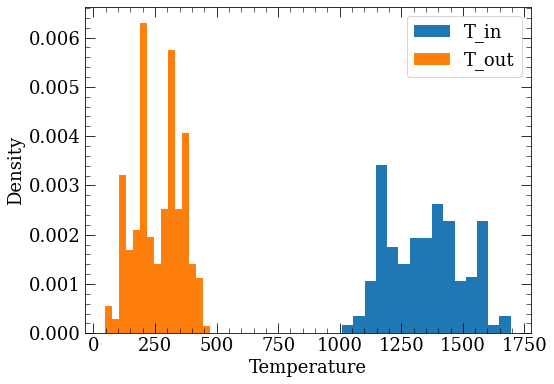

In [326]:
prms = np.array(prms)

plt.hist(prms[:, 0], label = 'T_in', density = True, bins = 15);
plt.hist(prms[:, 1], label = 'T_out', density = True, bins = 15);

plt.legend()

plt.xlabel('Temperature')
plt.ylabel('Density')

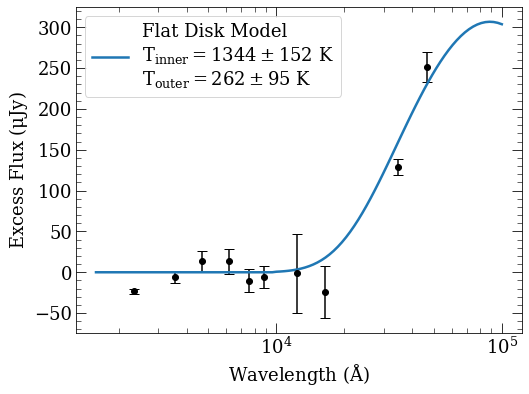

In [327]:
T_in, T_out = np.mean(prms, axis = 0)
e_T_in, e_T_out = np.std(prms, axis = 0)

disk_sed = disk_model(wl_grid, D, i, T_star, R_star, T_in, T_out)
plt.errorbar(IR_wls, IR_excess * 1e6, yerr = e_fluxes * 1e6, color = 'k', 
             linestyle = 'none', marker = 'o', capsize = 5)

plt.plot(wl_grid, disk_sed * 1e6, color = 'C0', linestyle = '-',lw = 2.5,
    label = 'Flat Disk Model\n$T_{inner} = %i \pm %i$ K\n$T_{outer} = %i \pm %i$ K' % (T_in, 
                                                                                       e_T_in, T_out, e_T_out))

#plt.yscale('log')
plt.xscale('log')

plt.ylabel('Excess Flux ($\mu$Jy)')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()

## Combined SED Plot

In [328]:
import matplotlib.ticker as ticker

In [329]:
grid = np.linspace(2000, 10**4, 5000)
grid = np.concatenate((grid,np.linspace(10**4+1, 9.9e4, 5000)))
excess_model = bb_model(grid, p[0], p[1])
disk_excess_model = disk_model(grid, D, i, T_star, R_star, T_in, T_out)

mlsigma = np.diff(grid)[0] * msigma * 2

In [330]:
bandnames = ['NUV', 'u', 'g', 'r', 'i', 'z', 'J', 'H', 'W1', 'W2']

In [331]:
plt.rcParams.update({'font.size': 18})

<ipython-input-338-1cea850af830>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ax.legend(np.array(handles)[sortidx],


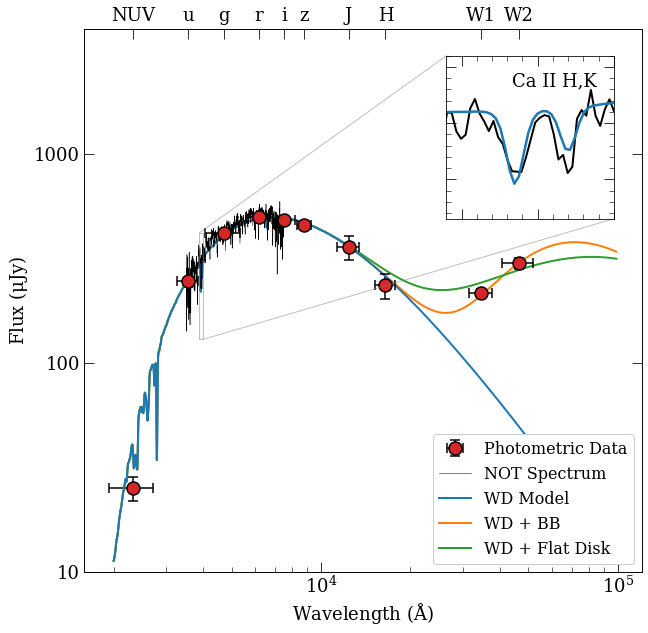

In [338]:
plt.figure(figsize = (10, 10))
plt.yscale('log')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux ($\mu$Jy)')
splinefunc = scipy.interpolate.CubicSpline(wls, fluxes)
lw = 2

#################### PLOT MODELS, SPECTRUM, AND PHOTOMETRY ####################

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH),mlsigma)\
         + excess_model, color = 'C1', 
         label = 'WD + BB', lw = lw)

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), mlsigma)\
         + disk_excess_model, color = 'C2',
         label = 'WD + Flat Disk',
        lw = lw, linestyle = '-')

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), mlsigma),
         color = 'C0', label = 'WD Model', lw = lw)

plt.plot(not_wl, ((not_fl / scipy.ndimage.gaussian_filter1d(not_fl, 100))) * splinefunc(not_wl), 'k', lw = 0.5,
        label = 'NOT Spectrum')

plt.errorbar(wls, fluxes, yerr = e_fluxes, color = 'tab:red', linestyle = 'none', marker = 'o', capsize = 5,
            label = 'Photometric Data', mew = 1.5, mec = 'k', markersize = 13, ecolor = 'k',
            xerr = bws/2)


#################### FORMAT AND SCALE AXES AND LABELS ####################

ax = plt.gca()
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6)) # change to micro-Jansky units
ax.yaxis.set_major_formatter(ticks)
plt.ylim(1e-5, 4e-3)
handles,labels = ax.get_legend_handles_labels()
sortidx = np.array([4, 3, 2, 0, 1])
ax.legend(np.array(handles)[sortidx],
          np.array(labels)[sortidx],loc = 'lower right', framealpha = 1, fontsize = 16)


#################### INSET ZOOM-IN TO CA DOUBLET ####################

axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
axins.plot(not_wl, ((not_fl / scipy.ndimage.gaussian_filter1d(not_fl, 100))) * splinefunc(not_wl) -  0.000015
           , 'k', lw = 2)
axins.plot(not_wl + 1.5, 
           scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = not_wl,
                                            cah = CAH), sigma = msigma) + 0.000015,
                                                   color = 'C0', label = 'WD', lw = 2.5)
x1, x2, y1, y2 = 3890, 4000, 13e-5, 42e-5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.text(0.9, 0.9, 'Ca II H,K', ha = 'right', va = 'top', transform = axins.transAxes)
ax.indicate_inset_zoom(axins)
ax.set_xscale('log')

#################### BAND NAMES ON TOP ####################

axtop = ax.twiny()
axtop.set_xlim(ax.get_xlim())
axtop.set_xscale('log')
axtop.set_xticks(wls)
axtop.set_xticklabels(bandnames)
axtop.minorticks_off()

plt.savefig('fig/d62_SED.pdf', bbox_inches = 'tight', dpi = 300)

## SED for JWST ETC

In [102]:
deepir = np.logspace(5, 6, 150)
deepbb = bb_model(deepir, p[0], p[1])
#deepbb = disk_model(deepir, D, i, T_star, R_star, res.x, 500)

In [103]:
approx_spec = get_cal_spec_wd(*bestfit, wl = grid, cah = CAH) + excess_model

In [104]:
approx_spec = np.concatenate((approx_spec, deepbb))
etc_grid = np.concatenate((grid, deepir))

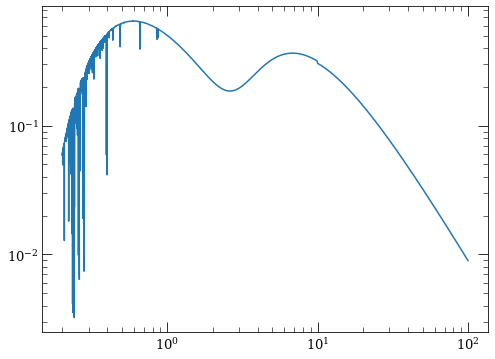

In [105]:
plt.plot(etc_grid/1e4, approx_spec * 1000)
plt.xscale('log')
plt.yscale('log')

In [106]:
etc_spec = np.vstack((etc_grid / 1e4, approx_spec * 1000)).T

In [79]:
np.savetxt('etc_spec.txt', etc_spec)

In [72]:
import pysynphot as psyn

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [73]:
sp = psyn.FileSpectrum('etc_spec.txt')